# MPD Mini-Project Sample

At this point in your project, you might not be sure about what you can do with the Materials Project Database. To help you think about what a potential project might look like I created a mini-research project. **You are not expected to know or understand the tools I'm using!** However, I have provided the code should you want to replicate them or create something similar (if fact you are encouraged to do so!). *There is no need to run the code in this notebook*

In this project I choose to look at material stability. As material scientists it would be nice to know if an experimentally submitted material could be synthesized in real life. In this notebook we will try and investigate this question. You may find this analysis relevant to your own project! Again, feel free to draw inspiration from this notebook and expand upon my work (feel free to ask me questions if there are parts you don’t understand).

In [9]:
### Imports ###
%matplotlib inline
import pymatgen as pmg
import seaborn as sns # This is a package for advanced stat plots. To download  ==> (conda install seaborn)
import matplotlib.pyplot as plt
from pymatgen import MPRester
import pandas as pd
import numpy as np

### Logging into MPD API ###
api_key = "______" # <== your key in the blank
mpr = pmg.MPRester(api_key)

### Figure Style ###
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

## Queries

First, we are going to need data from the materials project! Below I'm performing two queries to create `in_icsd` and `not_in_icsd`. These are two datasets collectively containing all materials in the materials project. `in_icsd` contains all materials that were cross referenced with experimentally synthesized materials in the [Inorganic Crystal Structure Database ICSD)](https://icsd.nist.gov/index.html) whereas `not_in_icsd` contains all remaining materials. 

**Note:** This is a pretty crude search and if you look at the respective datasets you may see this (e.g., there are `mvc-#####` and `mp-#####` id's in the `not_in_icsd` dataset). As you are constructing queries you may also want to consider cleaning your data and creating more refined searches.

**!WARNING! These are large queries and are intensive on the Materials Project servers. Please only perform queries like this sparingly and with caution.**

In [2]:
with MPRester(api_key) as mpr:
    search1 = mpr.query({'icsd_ids.0': {'$exists': True}}, ["material_id", "crystal_system", 'formation_energy_per_atom', 'energy', 'e_above_hull', "band_gap"])
    print("Search returned", len(search1), "material(s)")
    in_icsd = pd.DataFrame(search1)
    display(in_icsd.head())

  0%|          | 0/48616 [00:00<?, ?it/s]

Search returned 48616 material(s)


,material_id,crystal_system,formation_energy_per_atom,energy,e_above_hull,band_gap
0,mp-1002207,cubic,0.987436,-18.422127,1.133216,0.0
1,mp-1006883,cubic,0.152385,-12.583684,0.169578,0.0
2,mp-1008601,tetragonal,-0.047648,-14.355757,0.033223,0.0
3,mp-1009078,cubic,0.288766,-14.483258,0.374053,0.0
4,mp-1009837,cubic,0.649670,-18.288061,0.649670,0.0


In [3]:
with MPRester(api_key) as mpr:
    search2 = mpr.query({'icsd_ids.0': {'$exists': False}}, ["material_id", "crystal_system", 'formation_energy_per_atom', 'energy', 'e_above_hull', "band_gap"])
    print("Search returned", len(search2), "material(s)")
    not_in_icsd = pd.DataFrame(search2)
    display(not_in_icsd.head())

  0%|          | 0/77660 [00:00<?, ?it/s]

Search returned 77660 material(s)


,material_id,crystal_system,formation_energy_per_atom,energy,e_above_hull,band_gap
0,mp-1014286,hexagonal,3.551663,-42.852322,3.551663,0.0000
1,mp-1017199,orthorhombic,0.375816,-17.676992,0.388237,0.0000
2,mp-1025415,cubic,-0.476291,-46.002586,0.000000,0.0000
3,mp-1025682,trigonal,-0.277502,-58.824436,0.067836,0.7032
4,mp-1025752,trigonal,-0.317876,-57.075322,0.083959,0.8976


In [5]:
in_icsd['in_icsd'] = True
not_in_icsd['in_icsd'] = False

all_data = pd.concat([in_icsd, not_in_icsd], ignore_index=True)

display(all_data.head())

,material_id,crystal_system,formation_energy_per_atom,energy,e_above_hull,band_gap,in_icsd
0,mp-1002207,cubic,0.987436,-18.422127,1.133216,0.0,True
1,mp-1006883,cubic,0.152385,-12.583684,0.169578,0.0,True
2,mp-1008601,tetragonal,-0.047648,-14.355757,0.033223,0.0,True
3,mp-1009078,cubic,0.288766,-14.483258,0.374053,0.0,True
4,mp-1009837,cubic,0.649670,-18.288061,0.649670,0.0,True


## Analysis

### Energy Above Hull

Materials in MPD have a property called "energy above hull". On the website `e_above_hull` is defined as:

<blockquote> The energy of decomposition of this material into the set of most stable materials at this chemical composition, in eV/atom. Stability is tested against all potential chemical combinations that result in the material's composition.</blockquote>

Let's take a closer look at energy above hull and examine the differences between materials found in ICSD and those not found in the ICSD. One way to do this is using a histogram! 

Most of the energies above hull are clustered around $0$ eV. It can be useful to useful to take the $\log$ of the energy above hull to create a broader distribution. You may have also noticed that the number of materials in `in_icsd` is less than the number of materials in `not_in_icsd`. Because of this it would not be fair to create a histogram of the raw counts, so instead we will use proportion of materials in the respective dataset.

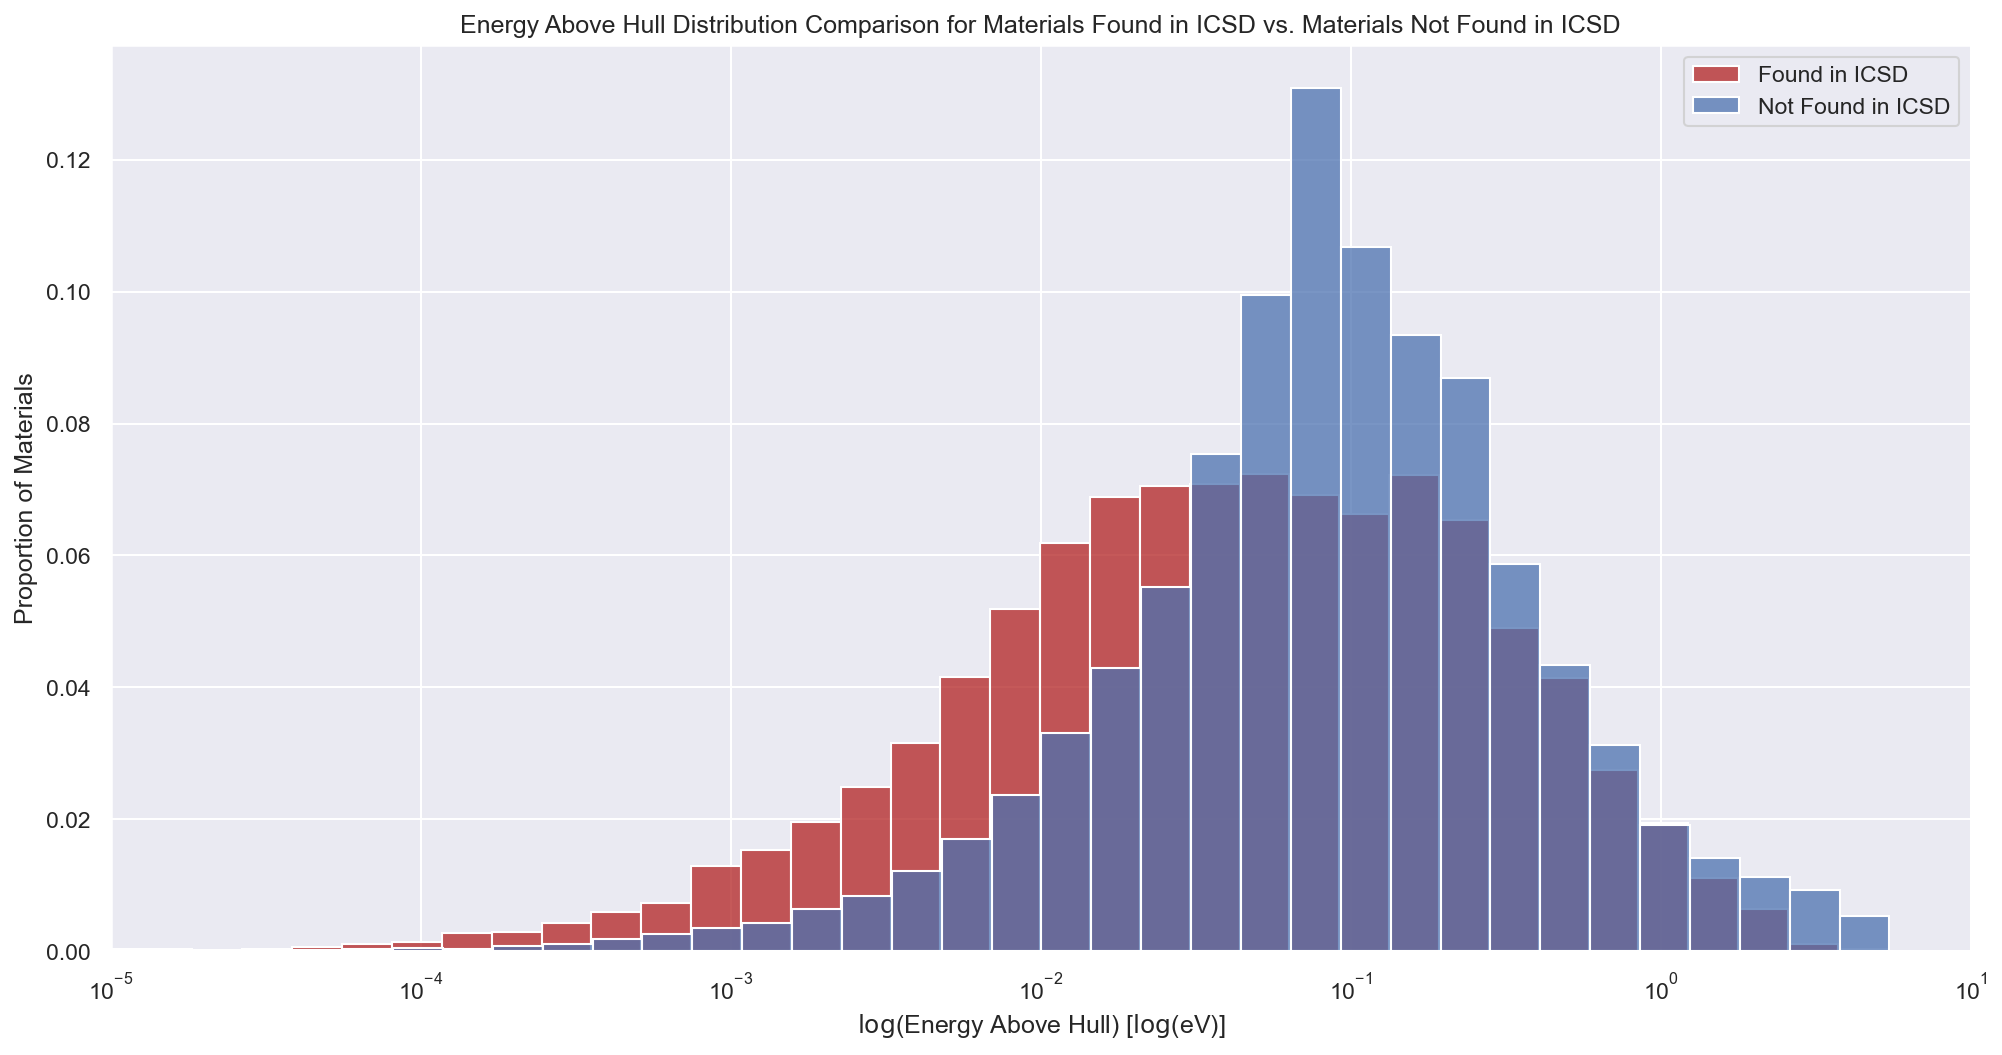

In [5]:
sns.histplot(in_icsd[in_icsd['e_above_hull'] > 0]['e_above_hull'], label = 'Found in ICSD', color = 'firebrick', bins = 100, stat = 'probability', log_scale = True)
sns.histplot(not_in_icsd[not_in_icsd['e_above_hull'] > 0]['e_above_hull'], label = 'Not Found in ICSD', bins = 100, stat = 'probability', log_scale = True)

plt.title('Energy Above Hull Distribution Comparison for Materials Found in ICSD vs. Materials Not Found in ICSD')
plt.xlabel('$\log$(Energy Above Hull) [$\log$(eV)]')
plt.ylabel('Proportion of Materials')
plt.xlim((10**-5, 10))
plt.legend();

From the plot above, we can see that the distribution of energy above hull for materials that were found in the ICSD are less than those that were not found in the ICSD. It appears that a smaller energy above hull tends to correspond to materials that can be experimentally created! However, this is not a hard and fast rule (as there is significant overlap between the two datasets)! 

Some other ways to represent this data would be to use boxplots and violin plots. I won't talk too much about them here but you can read up on them (or ask me about them)!
* Seaborn: [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot), [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html?highlight=violin%20plot#seaborn.violinplot)
* UC Berkeley Data 100 [Textbook](http://www.textbook.ds100.org/ch/10/viz_quantitative.html)

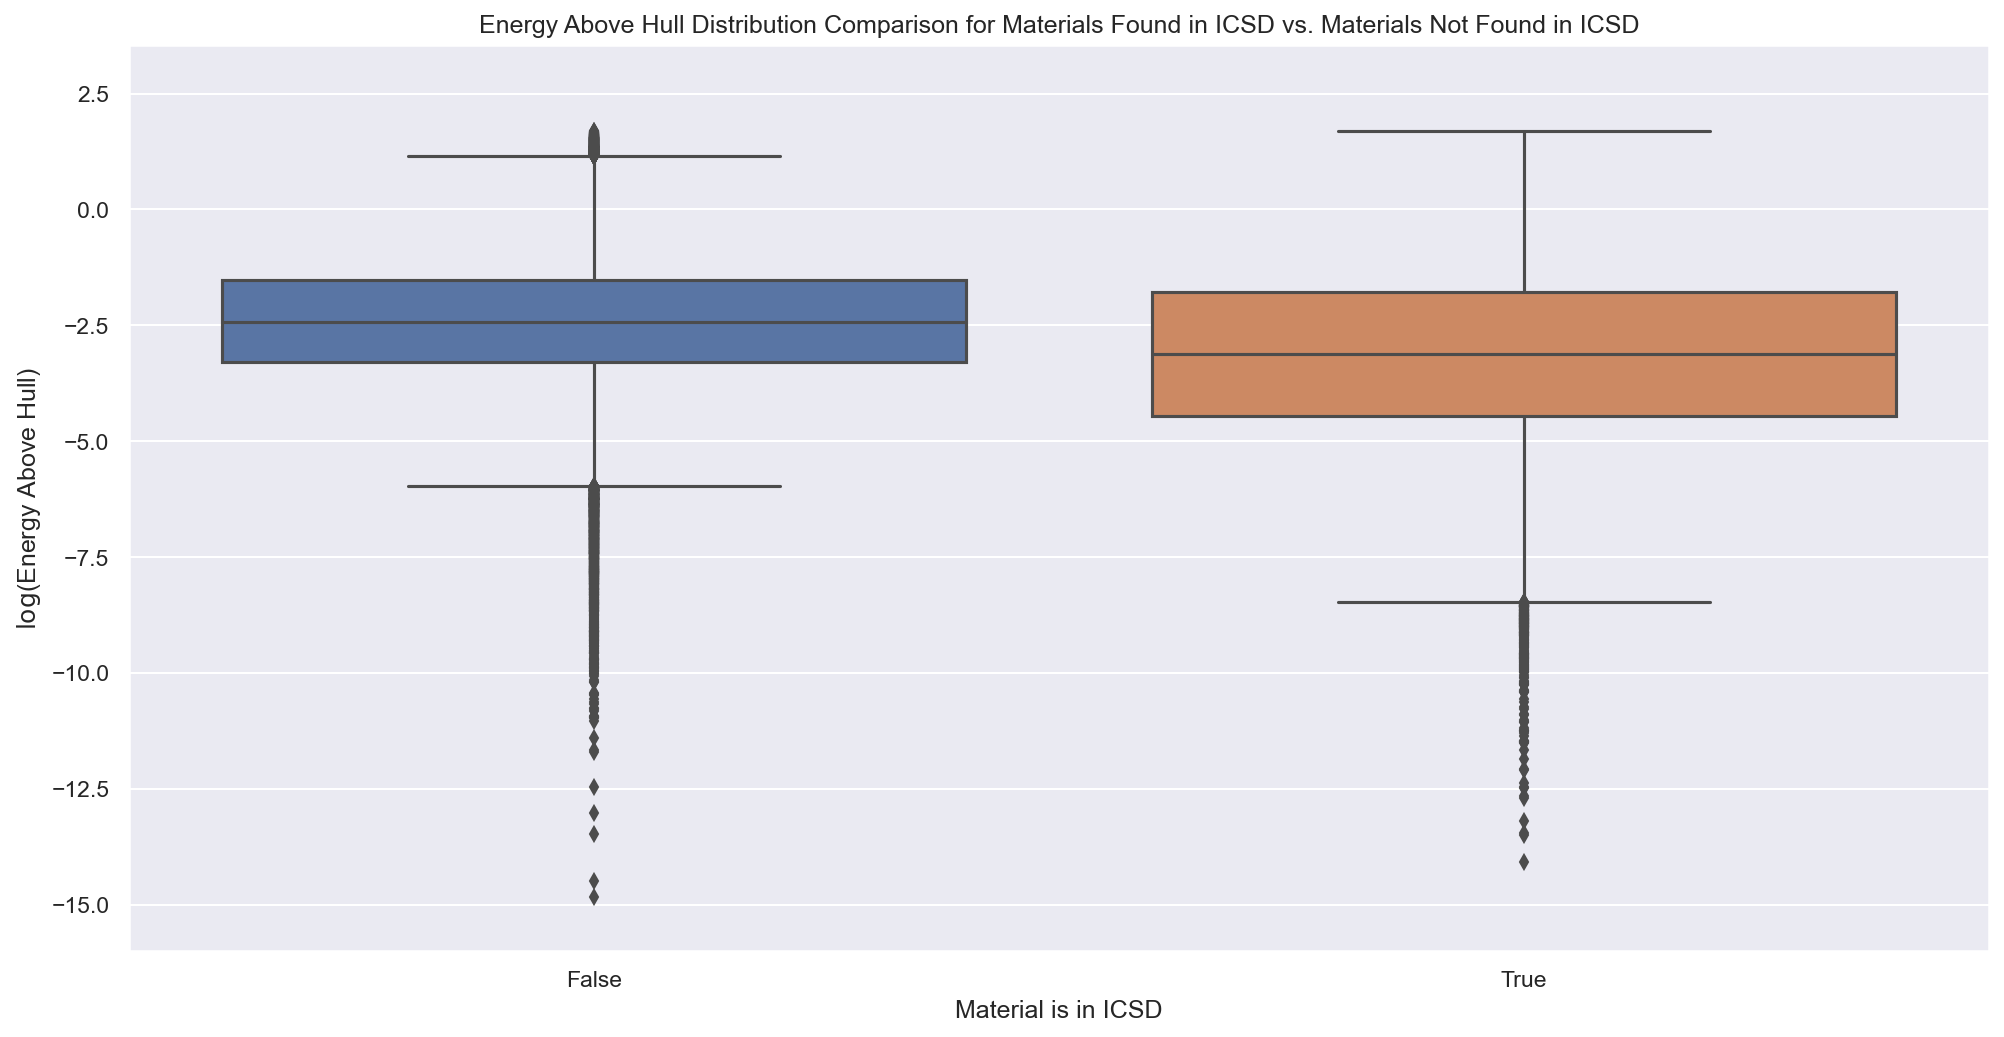

In [13]:
sns.boxplot(x = "in_icsd", y = np.log(all_data[all_data["e_above_hull"] > 0]['e_above_hull']), data=all_data)

plt.ylim(bottom = -16)
plt.title('Energy Above Hull Distribution Comparison for Materials Found in ICSD vs. Materials Not Found in ICSD')
plt.xlabel('Material is in ICSD')
plt.ylabel('$\log$(Energy Above Hull)');

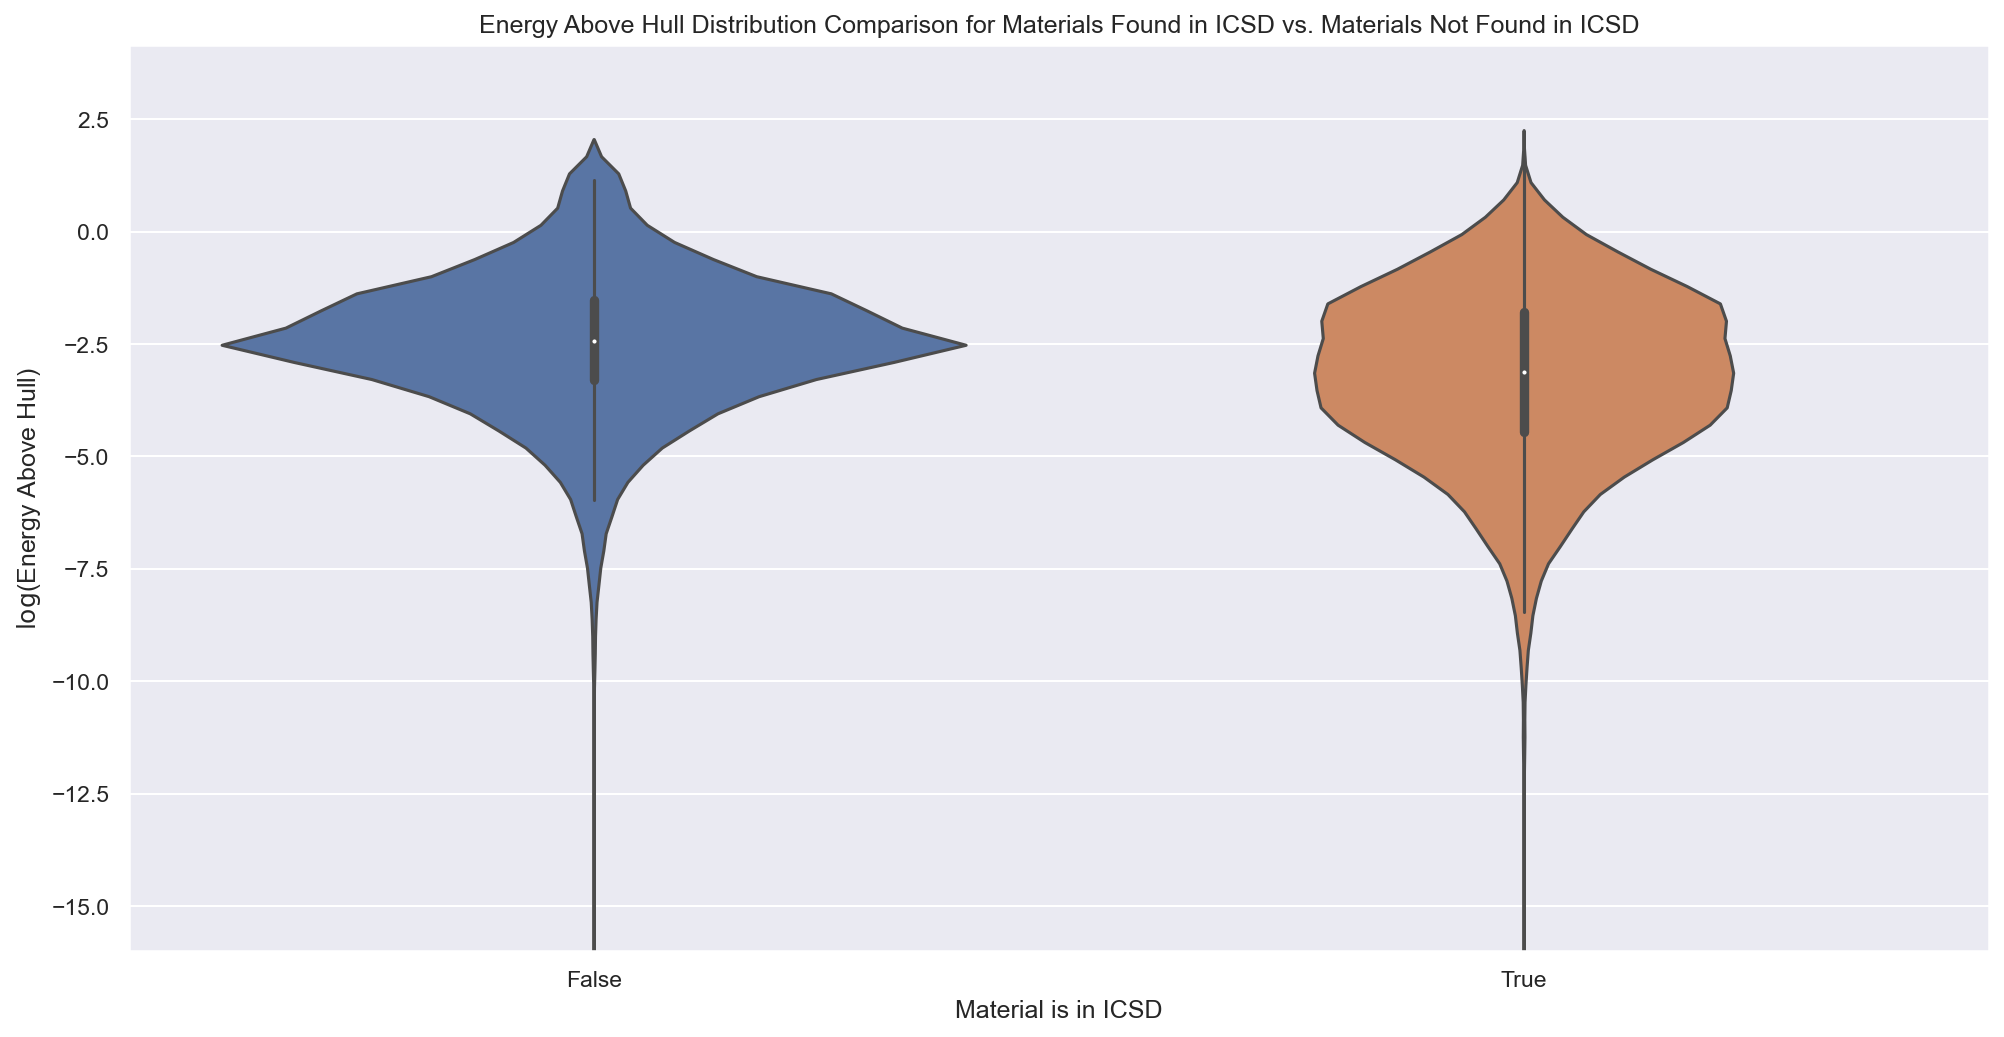

In [16]:
sns.violinplot(x = "in_icsd", y = np.log(all_data[all_data["e_above_hull"] > 0]['e_above_hull']), data=all_data)

plt.ylim(bottom = -16)
plt.title('Energy Above Hull Distribution Comparison for Materials Found in ICSD vs. Materials Not Found in ICSD')
plt.xlabel('Material is in ICSD')
plt.ylabel('$\log$(Energy Above Hull)');
# Totally unrelated, but not in ICSD looks very bird like!

### Band Gaps
Not let's take a look at another material property! We might wonder how the band gaps of theoretical (or yet to be created materials) compare to real materials. Are they smaller? Larger? Bi-modal or unimodal? We can create a second histogram to examine this question!

**Note:** I have added something call a kernel density estimation (kde) to these plots to estimate what a smooth distribution would look like. This is the solid line on the figure.

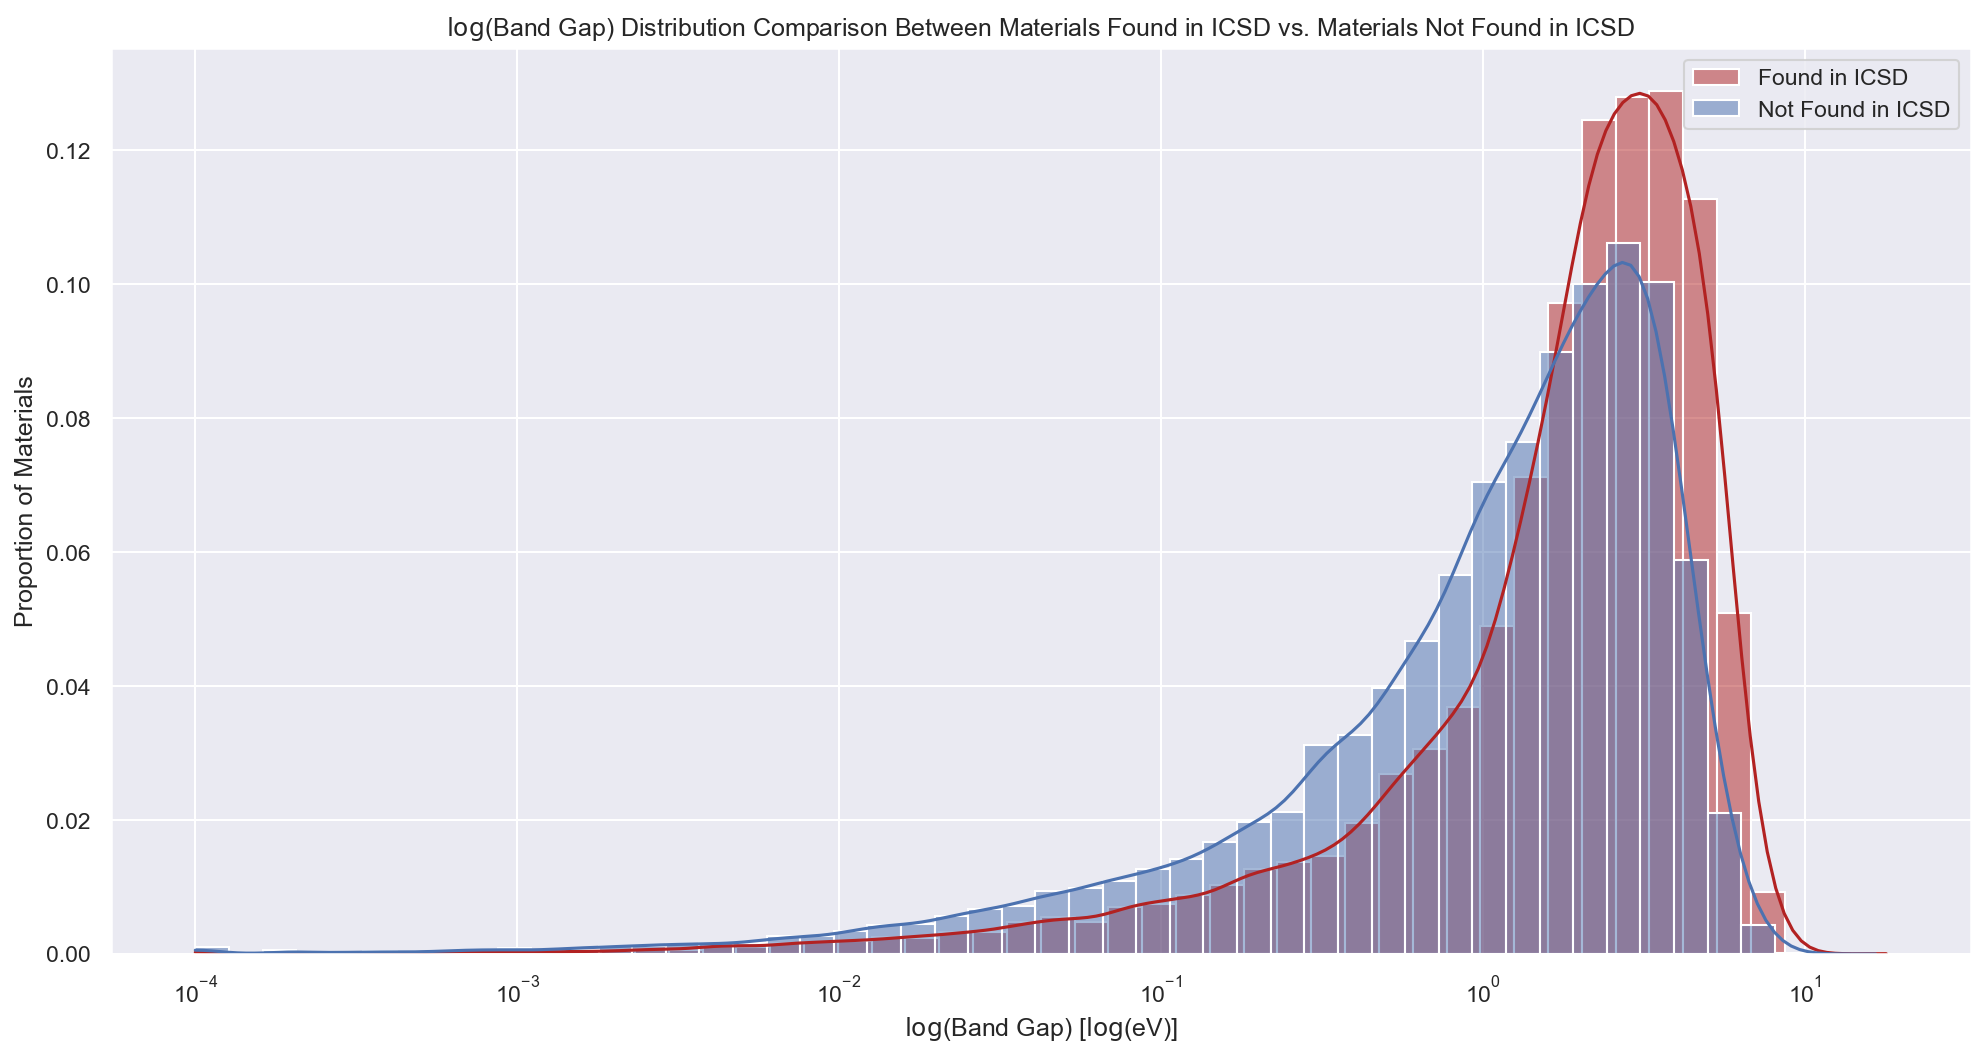

In [6]:
sns.histplot(in_icsd[in_icsd['band_gap'] > 0]['band_gap'], label = 'Found in ICSD', color = 'firebrick', bins = 50, stat = 'probability', log_scale = True, kde = True)
sns.histplot(not_in_icsd[not_in_icsd['band_gap'] > 0]['band_gap'], label = 'Not Found in ICSD', bins = 50, stat = 'probability', log_scale = True, kde = True)

plt.title(r'$\log$(Band Gap) Distribution Comparison Between Materials Found in ICSD vs. Materials Not Found in ICSD')
plt.xlabel(r'$\log$(Band Gap) [$\log$(eV)]')
plt.ylabel('Proportion of Materials')
plt.legend();

Looking that this distribution we can see that the band gaps for experimentally created materials tend to be between $1$ and $10$ eV. Additionally, many band gaps are less than $10$ eV creating a left skewed dataset. Looking at theoretical (or yet to be created) the distribution of band gaps skews towards smaller values. You might wonder why this is the case! Now would be a good time to take a closer examination of the data and apply some chemical reasoning to obtain greater insight. 

### Energy Above Hull vs. Formation Energy
Now let's try looking at how two material properties relate to one another. To do this let's start by plotting energy above hull vs. formation energy per atom for each material in `in_icsd` and `not_in_icsd`.

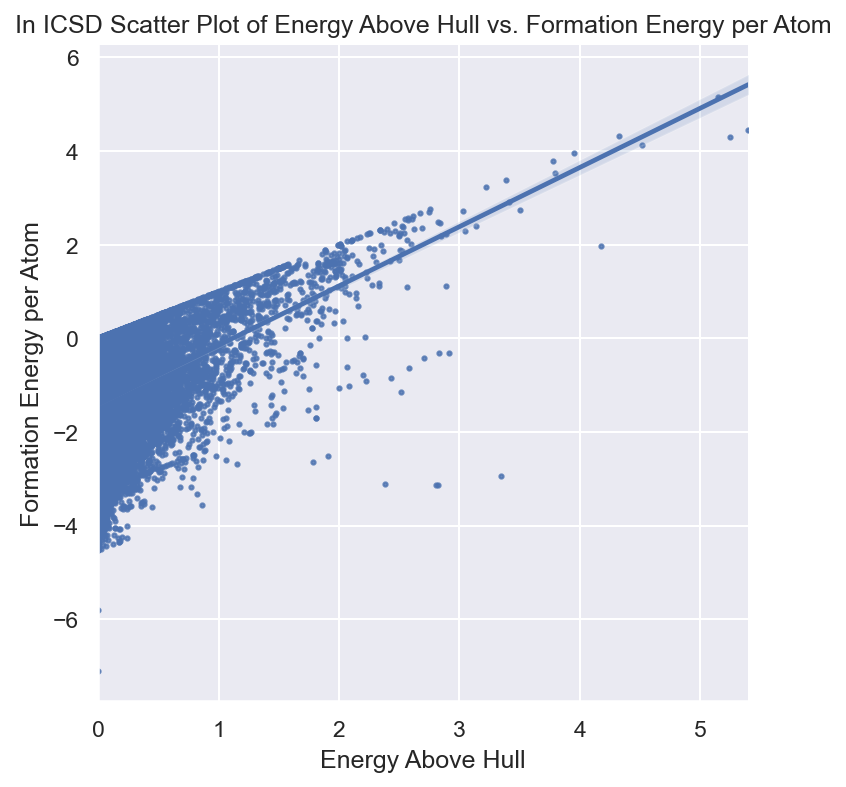

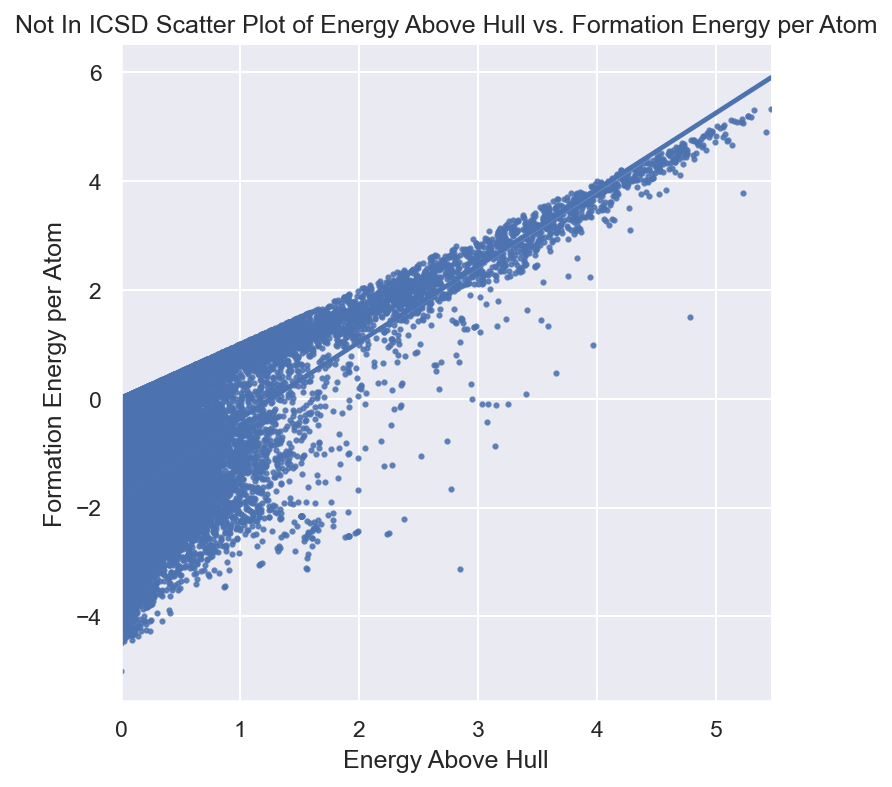

In [7]:
sns.lmplot(data = in_icsd, x = 'e_above_hull', y = 'formation_energy_per_atom', scatter_kws={"s": 4})
plt.title('In ICSD Scatter Plot of Energy Above Hull vs. Formation Energy per Atom')
plt.xlabel('Energy Above Hull')
plt.ylabel('Formation Energy per Atom');

sns.lmplot(data = not_in_icsd, x = 'e_above_hull', y = 'formation_energy_per_atom', scatter_kws={"s": 4})
plt.title('Not In ICSD Scatter Plot of Energy Above Hull vs. Formation Energy per Atom')
plt.xlabel('Energy Above Hull')
plt.ylabel('Formation Energy per Atom');

There appears to be a large clustering of materials around $0$ to $1$ eV energy above hull and $-4.0$ to $0$ eV formation energy per atom (but it's hard to tell exactly what is going on due to overplotting). Additionally, we can observe an interesting trend where the maximum formation energy per atom appears to increase linearly with energy above hull. Why is this? Well, it might have to do with how the energy above hull is calculated. We should look into the calculations for energy above hull more closely to see if this is the case.

If you end up working with very large datasets where overplotting becomes an issue you may want to consider using a kernel density estimate for plots like this. This means we instead create a plot of the density of point a region of space (this is not quite what is going on, see the next section). This leads to a kind of contour plot where different regions represent more (or less) points. We could also achieve a similar effect by greatly decreasing the opacity of each marker.

Performing such an operation of the first scatter plot of `in_icsd` dataset would look like the following.

**Note:** This is a pretty advanced plot and you are by no means expected to create something like this (it is merely an approach that you may find helpful)!

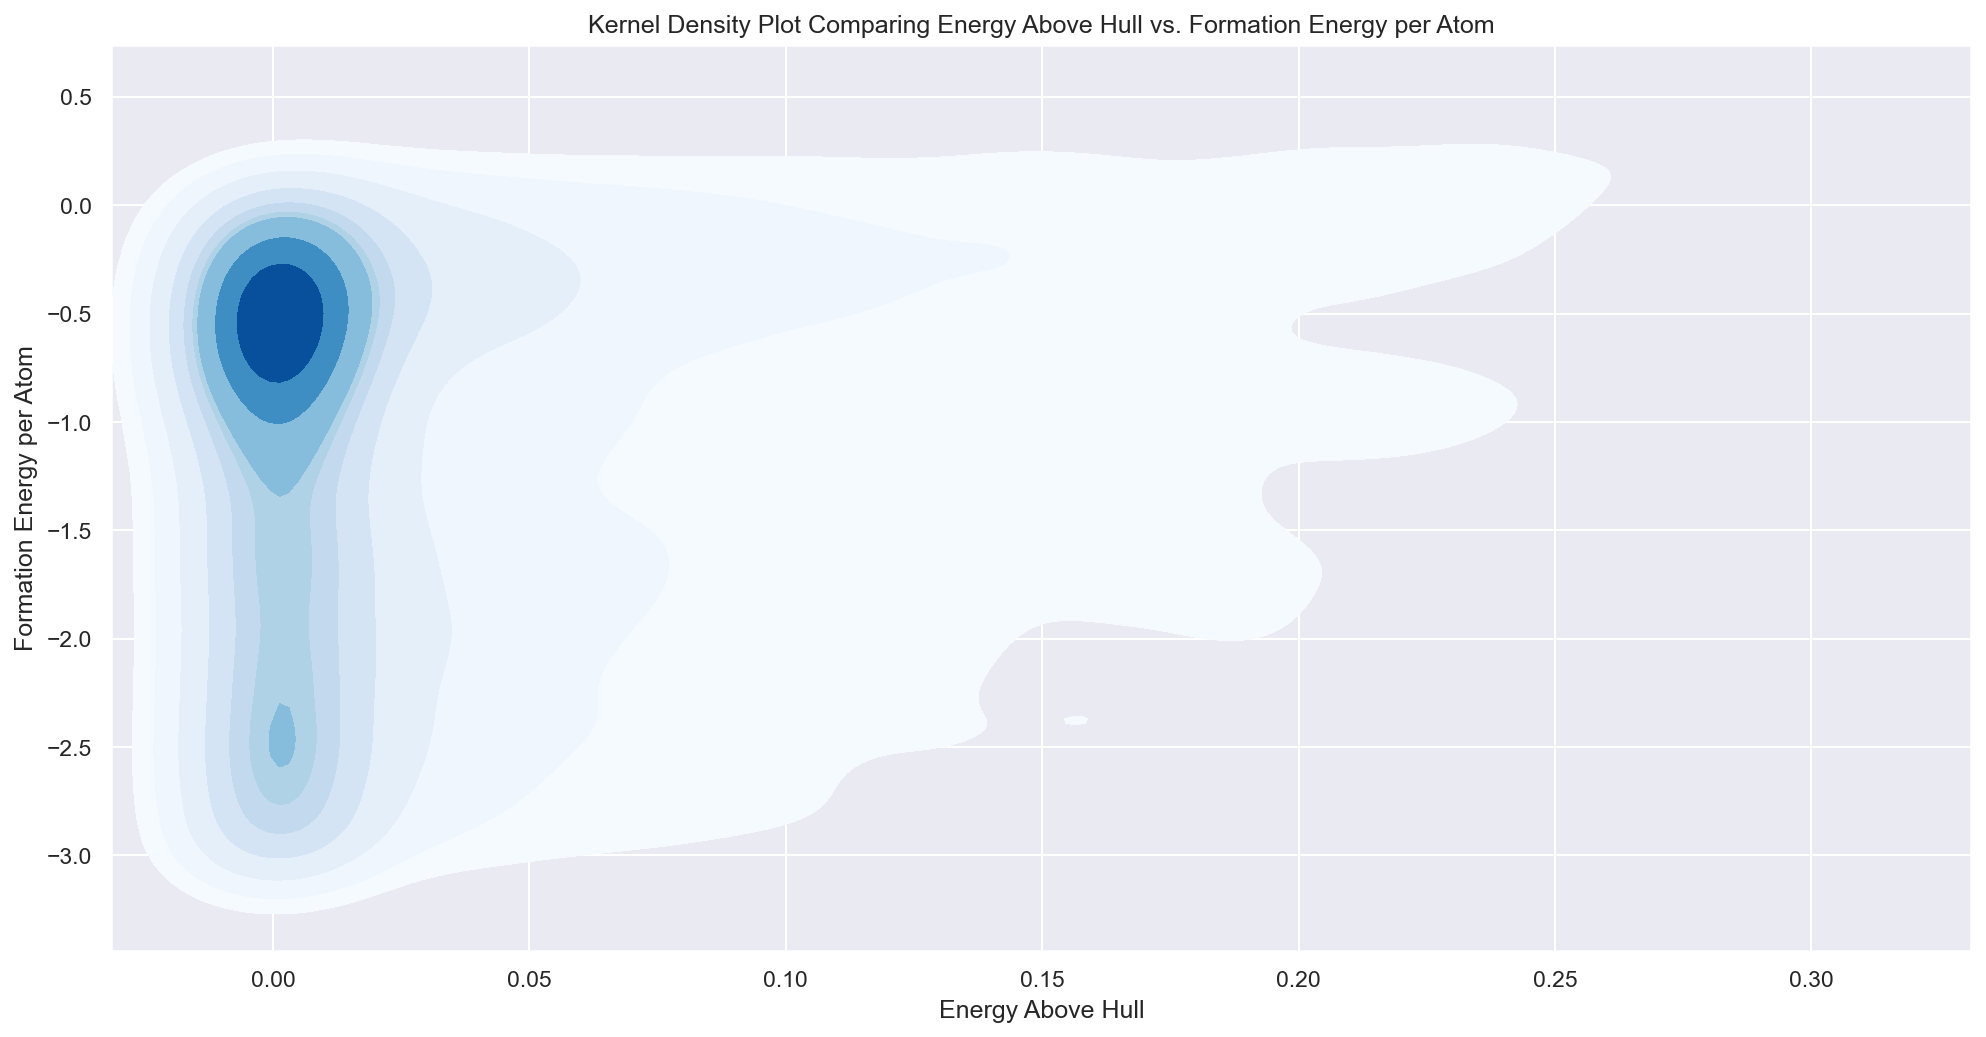

In [8]:
# This will take a minute to load.
sns.kdeplot(y = in_icsd[in_icsd['formation_energy_per_atom'] > -3]['formation_energy_per_atom'], x = in_icsd[in_icsd['e_above_hull'] < 0.3]['e_above_hull'], cmap = 'Blues', shade = True)

plt.title('Kernel Density Plot Comparing Energy Above Hull vs. Formation Energy per Atom')
plt.xlabel('Energy Above Hull')
plt.ylabel('Formation Energy per Atom');

You will notice that this doesn't perfectly reflect the results we found in our scatter plot (e.g., there are negative energy above hull regions). This is because these plots a bit more complex than just the density of points in a region (they are the sum small gaussian functions at each point in the dataset). Talk to me if you want to learn more about these plots!

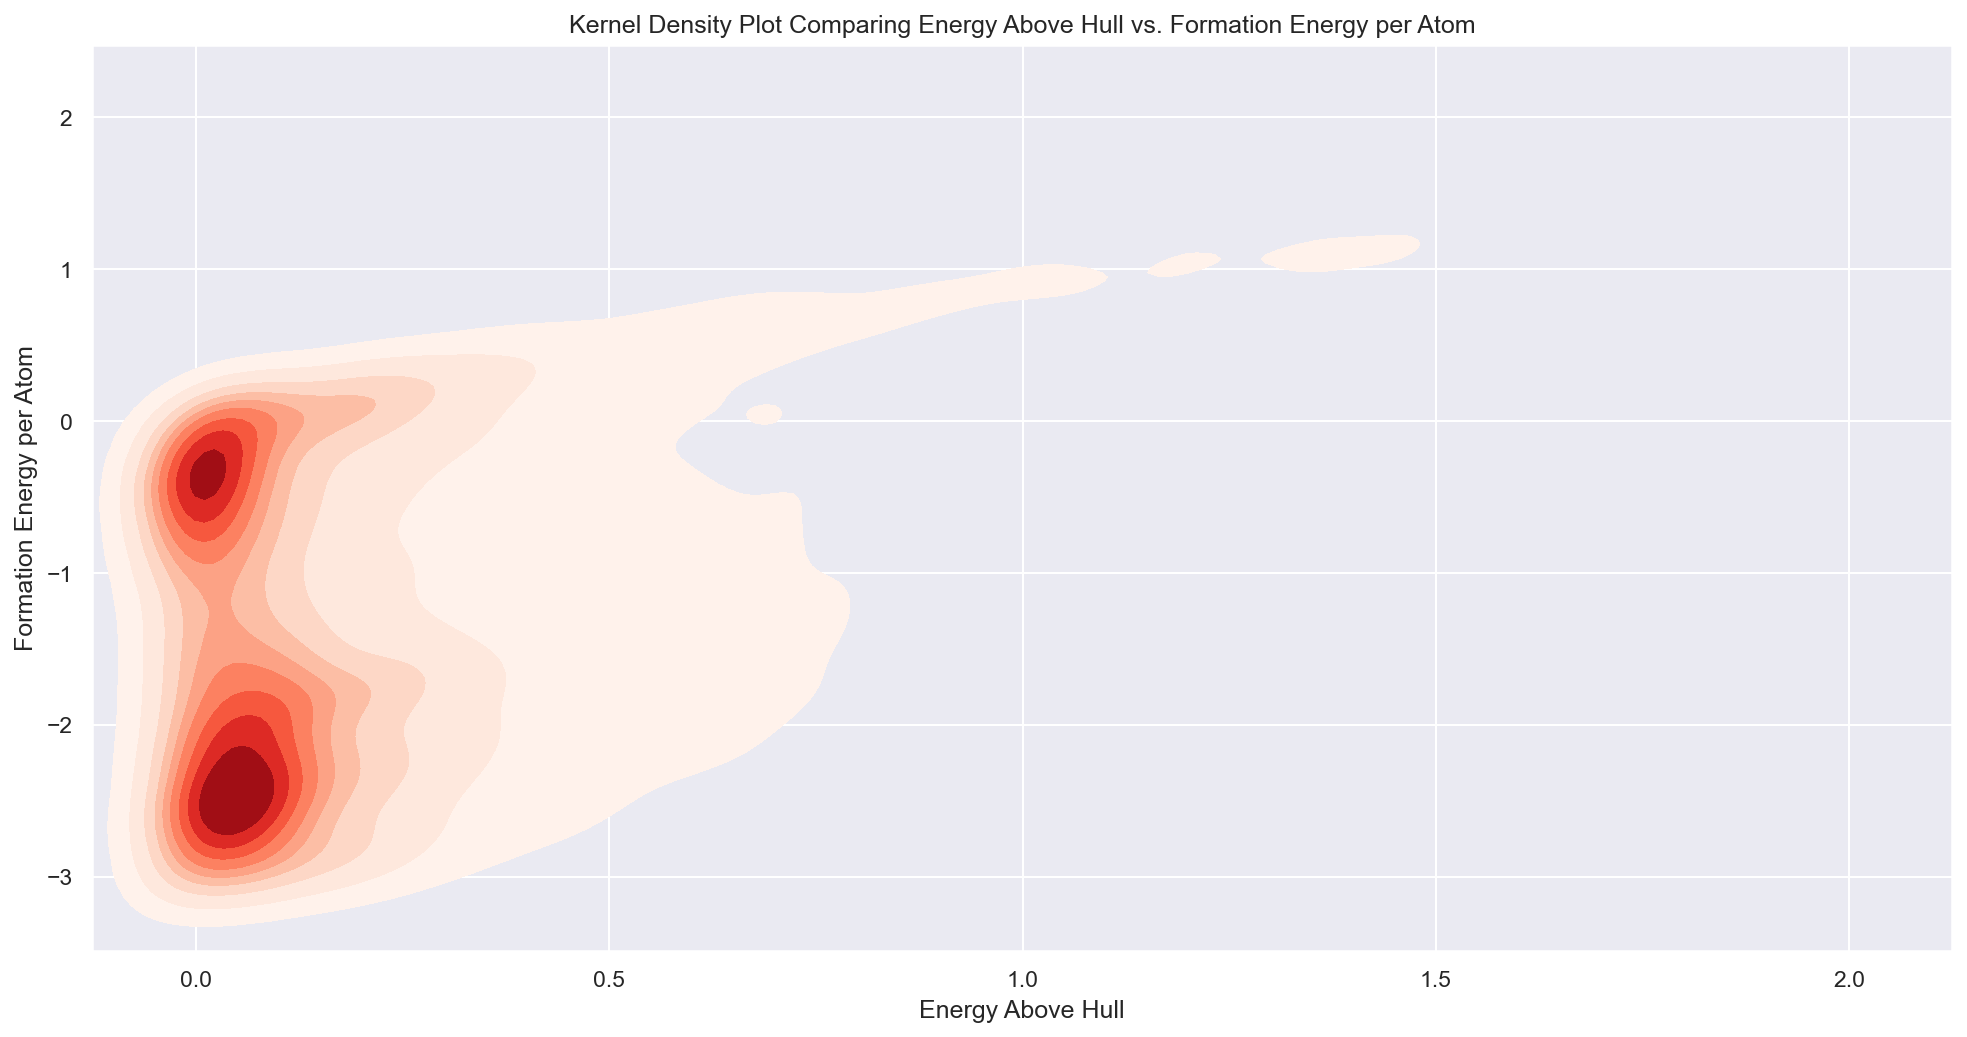

In [17]:
# Here's the second dataset just for fun!
sns.kdeplot(y = not_in_icsd[not_in_icsd['formation_energy_per_atom'] > -3]['formation_energy_per_atom'], x = not_in_icsd[not_in_icsd['e_above_hull'] < 2]['e_above_hull'], cmap = 'Reds', shade = True)

plt.title('Kernel Density Plot Comparing Energy Above Hull vs. Formation Energy per Atom')
plt.xlabel('Energy Above Hull')
plt.ylabel('Formation Energy per Atom');